In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.environments import stationary_stochastic_per_arm_py_environment as p_a_env
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

nest = tf.nest

# Simple Example

In [2]:
# The dimension of the global features.
GLOBAL_DIM = 40  #@param {type:"integer"}

# The elements of the global feature will be integers in [-GLOBAL_BOUND, GLOBAL_BOUND).
GLOBAL_BOUND = 10  #@param {type:"integer"}

# The dimension of the per-arm features.
PER_ARM_DIM = 50  #@param {type:"integer"}

# The elements of the PER-ARM feature will be integers in [-PER_ARM_BOUND, PER_ARM_BOUND).
PER_ARM_BOUND = 6  #@param {type:"integer"}

# The variance of the Gaussian distribution that generates the rewards.
VARIANCE = 100.0  #@param {type: "number"}

# The elements of the linear reward parameter will be integers in [-PARAM_BOUND, PARAM_BOUND).
PARAM_BOUND = 10  #@param {type: "integer"}

NUM_ACTIONS = 70  #@param {type:"integer"}
BATCH_SIZE = 20  #@param {type:"integer"}

# Parameter for linear reward function acting on the
# concatenation of global and per-arm features.
reward_param = list(np.random.randint(
      -PARAM_BOUND, PARAM_BOUND, [GLOBAL_DIM + PER_ARM_DIM]))

### A Simple Per-Arm Environment
The stationary stochastic environment, explained in the other tutorial, has a per-arm counterpart.

To initialize the per-arm environment, one has to define functions that generate

* `global and per-arm features`: These functions have no input parameters and generate a single (global or per-arm) feature vector when called.
* `rewards`: This function takes as parameter the concatenation of a global and a per-arm feature vector, and generates a reward. Basically this is the function that the agent will have to "guess". It is worth noting here that in the per-arm case the reward function is identical for every arm. This is a fundamental difference from the classic bandit case, where the agent has to estimate reward functions for each arm independently.

In [3]:
def global_context_sampling_fn():
    """
    This function generates a single global observation vector.
    """
    return np.random.randint(
        -GLOBAL_BOUND
        , GLOBAL_BOUND
        , [GLOBAL_DIM]
    ).astype(np.float32)

def per_arm_context_sampling_fn():
    """"
    This function generates a single per-arm observation vector.
    """
    return np.random.randint(
        -PER_ARM_BOUND
        , PER_ARM_BOUND
        , [PER_ARM_DIM]
    ).astype(np.float32)

def linear_normal_reward_fn(x):
    """
    This function generates a reward from the concatenated global and per-arm observations.
    """
    mu = np.dot(x, reward_param)
    return np.random.normal(mu, VARIANCE)

In [4]:
per_arm_py_env = p_a_env.StationaryStochasticPerArmPyEnvironment(
    global_context_sampling_fn,
    per_arm_context_sampling_fn,
    NUM_ACTIONS,
    linear_normal_reward_fn,
    batch_size=BATCH_SIZE
)

per_arm_tf_env = tf_py_environment.TFPyEnvironment(per_arm_py_env)
per_arm_tf_env

We see that the observation spec is a dictionary with two elements:

* One with key `'global'`: this is the global context part, with shape matching the parameter `GLOBAL_DIM`.
* One with key `'per_arm'`: this is the per-arm context, and its shape is `[NUM_ACTIONS, PER_ARM_DIM]`. This part is the placeholder for the arm features for every arm in a time step.

In [5]:
print('observation spec: ', per_arm_tf_env.observation_spec())
print('\nAn observation: ', per_arm_tf_env.reset().observation)

action = tf.zeros(BATCH_SIZE, dtype=tf.int32)
time_step = per_arm_tf_env.step(action)
print('\nRewards after taking an action: ', time_step.reward)

observation spec:  {'global': TensorSpec(shape=(40,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(70, 50), dtype=tf.float32, name=None)}


2023-07-11 11:25:20.905935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 11:25:20.907809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 11:25:20.913677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf


An observation:  {'global': <tf.Tensor: shape=(20, 40), dtype=float32, numpy=
array([[ -7.,  -2.,   7.,  -9.,  -1.,   8.,  -2.,   1., -10.,   7.,   4.,
          6.,   0.,  -3.,  -5.,  -9.,   0.,  -5., -10.,   1., -10.,   7.,
         -7.,   3.,   6.,  -6.,  -2.,  -6.,   0.,   6., -10.,  -6.,   2.,
         -3.,   1.,  -3.,  -5.,   7.,   1.,  -1.],
       [ -2.,   6.,   1.,   6.,   2.,   7.,  -2.,  -2.,   9.,  -1.,   6.,
         -8.,  -9.,   9.,  -9.,   2.,  -8.,   6.,  -4.,  -5.,   6.,  -4.,
         -4.,  -5.,  -9.,  -3.,  -2.,   8.,   6.,  -8.,  -5.,   7.,  -1.,
         -8.,   8.,  -6.,   8., -10.,  -2.,   5.],
       [  6.,   2.,   4., -10.,  -4.,   8.,   8.,   5.,   8.,   8.,   6.,
          3.,   3.,  -9.,   9.,  -8.,   8.,   1.,  -8.,   9.,   1.,   8.,
         -9.,   8.,  -2.,   2.,   5.,   6.,  -2.,   8.,   8., -10.,   6.,
         -8.,   1.,   0.,  -6.,  -3.,   0.,   2.],
       [  7.,  -3.,  -1.,  -4.,   3.,  -8.,   9.,  -9.,   8.,   2.,  -1.,
         -2.,   0.,  -7.,   

In [6]:
observation_spec = per_arm_tf_env.observation_spec()

time_step_spec = ts.time_step_spec(observation_spec)

action_spec = tensor_spec.BoundedTensorSpec(
    dtype=tf.int32
    , shape=()
    , minimum=0
    , maximum=NUM_ACTIONS - 1
)

agent = lin_ucb_agent.LinearUCBAgent(
    time_step_spec=time_step_spec
    , action_spec=action_spec
    , accepts_per_arm_features=True
)

## The Flow of Training Data

First, let us have a look at the data specification in the agent. 

The `training_data_spec` attribute of the agent specifies what elements and structure the training data should have.

In [7]:
print('training data spec: ', agent.training_data_spec)

training data spec:  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(69, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(40,), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=(), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(50,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


If we have a closer look to the `observation` part of the spec, we see that it does not contain per-arm features!

In [8]:
print('observation spec in training: ', agent.training_data_spec.observation)

observation spec in training:  {'global': TensorSpec(shape=(40,), dtype=tf.float32, name=None)}


What happened to the per-arm features? To answer this question, first we note that when the LinUCB agent trains:
* **does not need the per-arm features of all arms**
* **only needs those of the chosen arm**

Hence, it makes sense to drop the tensor of shape `[BATCH_SIZE, NUM_ACTIONS, PER_ARM_DIM]`, as it is very wasteful, especially if the number of actions is large.

But still, the per-arm features of the chosen arm must be somewhere! To this end, we make sure that the LinUCB policy stores the features of the chosen arm within the `policy_info` field of the training data:

In [9]:
print('chosen arm features: ', agent.training_data_spec.policy_info.chosen_arm_features)

chosen arm features:  TensorSpec(shape=(50,), dtype=tf.float32, name=None)


We see from the shape that the `chosen_arm_features` field has only the feature vector of one arm, and that will be the chosen arm. Note that the `policy_info`, and with it the `chosen_arm_features`, is part of the training data, as we saw from inspecting the training data spec, and thus it is available at training time.

## Defining the Regret Metric

Before starting the training loop, we define some utility functions that help calculate the regret of our agent. These functions help determining the optimal expected reward given the set of actions (given by their arm features) and the linear parameter that is hidden from the agent.

In [10]:
def _all_rewards(observation, hidden_param):
    """
    Outputs rewards for all actions, given an observation.
    """
    hidden_param = tf.cast(hidden_param, dtype=tf.float32)
    global_obs = observation['global']
    per_arm_obs = observation['per_arm']
    num_actions = tf.shape(per_arm_obs)[1]
    
    tiled_global = tf.tile(
        tf.expand_dims(global_obs, axis=1)
        , [1, num_actions, 1]
    )
    
    concatenated = tf.concat([tiled_global, per_arm_obs], axis=-1)
    rewards = tf.linalg.matvec(concatenated, hidden_param)
    return rewards

def optimal_reward(observation):
    """
    Outputs the maximum expected reward for every element in the batch.
    """
    return tf.reduce_max(_all_rewards(observation, reward_param), axis=1)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward)  

Now we are all set for starting our bandit training loop. The driver below takes care of choosing actions using the policy, storing rewards of chosen actions in the replay buffer, calculating the predefined regret metric, and executing the training step of the agent.

In [11]:
num_iterations = 20 # @param
steps_per_loop = 1 # @param

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=BATCH_SIZE,
    max_length=steps_per_loop)

observers = [replay_buffer.add_batch, regret_metric]

driver = dynamic_step_driver.DynamicStepDriver(
    env=per_arm_tf_env,
    policy=agent.collect_policy,
    num_steps=steps_per_loop * BATCH_SIZE,
    observers=observers)

regret_values = []

for _ in range(num_iterations):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    regret_values.append(regret_metric.result())

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


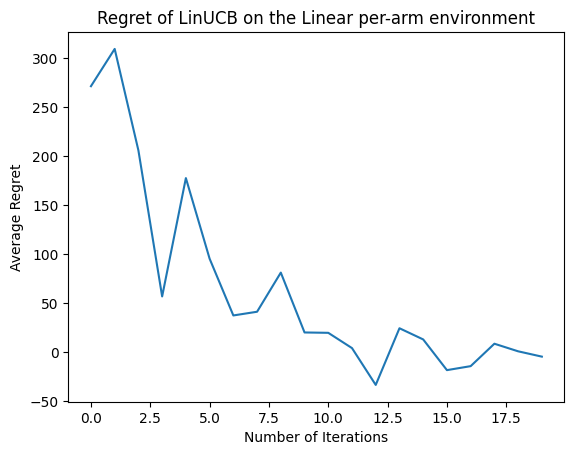

In [12]:
plt.plot(regret_values)
plt.title('Regret of LinUCB on the Linear per-arm environment')
plt.xlabel('Number of Iterations')
_ = plt.ylabel('Average Regret')

# Movielens example

Now consider the scenario where an agent recommends to a user the next movie to watch. Every time a decision has to be made, the agent receives as context some information about the user (watch history, genre preference, etc...), as well as the list of movies to choose from.

We could try to formulate this problem by having the user information as the context and the arms would be movie_1, movie_2, ..., movie_K, but this approach has multiple shortcomings:

* The number of actions would have to be all the movies in the system and it is cumbersome to add a new movie.
* The agent has to learn a model for every single movie.
* Similarity between movies is not taken into account.

Instead of numbering the movies, we can do something more intuitive: we can represent movies with a set of features including genre, length, cast, rating, year, etc. The advantages of this approach are manifold:

* Generalisation across movies.
* The agent learns just one reward function that models reward with user and movie features.
* Easy to remove from, or introduce new movies to the system.

In [ ]:
# The dimension of the global features.
GLOBAL_DIM = 40  # 40 users

# The elements of the global feature will be integers in [-GLOBAL_BOUND, GLOBAL_BOUND).
GLOBAL_BOUND = 10  # of each user, -10,10 to describe user features

# The dimension of the per-arm features.
PER_ARM_DIM = 50  # movies

# The elements of the PER-ARM feature will be integers in [-PER_ARM_BOUND, PER_ARM_BOUND).
PER_ARM_BOUND = 6  # cardinality of movie feature

# The variance of the Gaussian distribution that generates the rewards.
VARIANCE = 100.0  #@param {type: "number"}

# The elements of the linear reward parameter will be integers in [-PARAM_BOUND, PARAM_BOUND).
PARAM_BOUND = 10  #@param {type: "integer"}

NUM_ACTIONS = 70  #@param {type:"integer"}
BATCH_SIZE = 20  #@param {type:"integer"}

# Parameter for linear reward function acting on the
# concatenation of global and per-arm features.
reward_param = list(np.random.randint(
      -PARAM_BOUND, PARAM_BOUND, [GLOBAL_DIM + PER_ARM_DIM]))

In [3]:
import tensorflow_datasets as tfds
from pprint import pprint

## Data
* see [here](https://www.tensorflow.org/datasets/catalog/movielens#movielens100k-ratings) for `Movielens` data dictionary

Movie recommendation
* `arms`: movies (items being recommended)
* `global_features`: **TODO**
* `arm_features`: **TODO**

### movies data

In [20]:
movies = tfds.load("movielens/100k-movies", split="train")

for x in movies.batch(1).take(1):
    pprint(x)

{'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[4]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'1681'], dtype=object)>,
 'movie_title': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'You So Crazy (1994)'], dtype=object)>}


#### unique movie IDs

In [23]:
unique_movie_ids = movies.map(lambda x: x["movie_id"])
unique_movie_ids = np.unique(np.concatenate(list(unique_movie_ids.batch(1000))))

print(f"len(unique_movie_ids) : {len(unique_movie_ids)}")
print(f"unique_movie_ids      : {unique_movie_ids[:2]}")

len(unique_movie_ids) : 1682
unique_movie_ids      : [b'1' b'10' b'100' ... b'997' b'998' b'999']


#### parsed movie feature dict

In [24]:
parsed_movies = movies.map(lambda x: {
    "movie_id": x["movie_id"]
    , "movie_title": x["movie_title"]
    , "movie_genres": x["movie_genres"]
})

for x in parsed_movies.batch(1).take(2):
    pprint(x)

{'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[4]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'1681'], dtype=object)>,
 'movie_title': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'You So Crazy (1994)'], dtype=object)>}
{'movie_genres': <tf.Tensor: shape=(1, 2), dtype=int64, numpy=array([[4, 7]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'1457'], dtype=object)>,
 'movie_title': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Love Is All There Is (1996)'], dtype=object)>}


### user and ratings data

In [25]:
ratings = tfds.load("movielens/100k-ratings", split="train")

for x in ratings.batch(1).take(1):
    pprint(x)

{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([45.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[7]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'357'], dtype=object)>,
 'movie_title': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b"One Flew Over the Cuckoo's Nest (1975)"], dtype=object)>,
 'raw_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([46.], dtype=float32)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([879024327])>,
 'user_gender': <tf.Tensor: shape=(1,), dtype=bool, numpy=array([ True])>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'138'], dtype=object)>,
 'user_occupation_label': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([4])>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'doctor'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>,

#### unique user IDs

In [31]:
# unique_user_ids = ratings.batch(1_000).map(lambda x: x["user_id"])
unique_user_ids = ratings.map(lambda x: x["user_id"])
unique_user_ids = np.unique(np.concatenate(list(unique_user_ids.batch(1000))))

print(f"len(unique_user_ids) : {len(unique_user_ids)}")
print(f"unique_user_ids      : {unique_user_ids[:2]}")

len(unique_user_ids) : 943
unique_user_ids      : [b'1' b'10']


#### parsed user feature dict

In [32]:
parsed_ratings = ratings.map(lambda x: {
    "movie_id": x["movie_id"]
    , "movie_title": x["movie_title"]
    , "movie_genres": x["movie_genres"]
    , "user_id": x["user_id"]
    , "user_occupation_label": x["user_occupation_label"]
    , "user_rating": x["user_rating"]
    , "timestamp": x["timestamp"]
})

for x in parsed_ratings.batch(1).take(1):
    pprint(x)

{'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'357'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([879024327])>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'138'], dtype=object)>,
 'user_occupation_label': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([4])>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>}


#### timestamp features

In [30]:
timestamps = np.concatenate(list(parsed_ratings.map(lambda x: x["timestamp"]).batch(1_000)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp
    , max_timestamp
    , num=1000
)

print(f"max_timestamp     : {max_timestamp}")
print(f"min_timestamp     : {min_timestamp}")
print(f"timestamp_buckets : {timestamp_buckets[:2]}")

max_timestamp     : 893286638
min_timestamp     : 874724710
timestamp_buckets : [8.74724710e+08 8.74743291e+08]


## Custom Networks

In [ ]:
from tf_agents.environments import random_py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.networks import encoding_network
from tf_agents.networks import network
from tf_agents.networks import utils
from tf_agents.specs import array_spec
from tf_agents.utils import common as common_utils
from tf_agents.utils import nest_utils

In [ ]:
class ActorNetwork(network.Network):

    def __init__(self,
                 observation_spec,
                 action_spec,
                 preprocessing_layers=None,
                 preprocessing_combiner=None,
                 conv_layer_params=None,
                 fc_layer_params=(75, 40),
                 dropout_layer_params=None,
                 activation_fn=tf.keras.activations.relu,
                 enable_last_layer_zero_initializer=False,
                 name='ActorNetwork'):
        super(ActorNetwork, self).__init__(
            input_tensor_spec=observation_spec, state_spec=(), name=name)

        # For simplicity we will only support a single action float output.
        self._action_spec = action_spec
        flat_action_spec = tf.nest.flatten(action_spec)
        if len(flat_action_spec) > 1:
            raise ValueError('Only a single action is supported by this network')
        
        self._single_action_spec = flat_action_spec[0]
        if self._single_action_spec.dtype not in [tf.float32, tf.float64]:
            raise ValueError('Only float actions are supported by this network.')

        kernel_initializer = tf.keras.initializers.VarianceScaling(
            scale=1. / 3.
            , mode='fan_in'
            , distribution='uniform'
        )
        
        self._encoder = encoding_network.EncodingNetwork(
            observation_spec
            , preprocessing_layers=preprocessing_layers
            , preprocessing_combiner=preprocessing_combiner
            , conv_layer_params=conv_layer_params
            , fc_layer_params=fc_layer_params
            , dropout_layer_params=dropout_layer_params
            , activation_fn=activation_fn
            , kernel_initializer=kernel_initializer
            , batch_squash=False
        )

        initializer = tf.keras.initializers.RandomUniform(
            minval=-0.003
            , maxval=0.003
        )

        self._action_projection_layer = tf.keras.layers.Dense(
            , flat_action_spec[0].shape.num_elements()
            , activation=tf.keras.activations.tanh
            , kernel_initializer=initializer
            , name='action'
        )

    def call(self, observations, step_type=(), network_state=()):
        outer_rank = nest_utils.get_outer_rank(observations, self.input_tensor_spec)
        
        # We use batch_squash here in case the observations have a time sequence
        # compoment.
        batch_squash = utils.BatchSquash(outer_rank)
        observations = tf.nest.map_structure(batch_squash.flatten, observations)

        state, network_state = self._encoder(
            observations
            , step_type=step_type
            , network_state=network_state
        )
        
        actions = self._action_projection_layer(state)
        actions = common_utils.scale_to_spec(actions, self._single_action_spec)
        actions = batch_squash.unflatten(actions)
        
        return tf.nest.pack_sequence_as(self._action_spec, [actions]), network_state

#### [internal] agent_trainer_common.py

* [src](https://critique.corp.google.com/cl/323064095/depot/google3/learning/smartchoices/training/models/agent_trainer_common.py)

In [ ]:
# Input data reader
READER = tf.data.RecordIODataset

def _create_dataset_fn(
    tf_transform_output
    , data_files
    , agent_wrapper
    , randomize_input=True
    , trajectory_fn=None
):
    """
    Creates the dataset_fn needed by the dataset wrapping replay buffer.
    """

    def _dataset_fn(
        batch_size
        , num_steps
        , sequence_preprocess_fn
        , num_parallel_calls
    ):
        """
        Creates tf.Dataset containing Trajectory objects.
        """

        if sequence_preprocess_fn is not None:
            raise NotImplementedError('sequence_preprocess_fn is not supported.')

        # TODO(dzats): Currently ignore numsteps. Determine how to handle this in
        # the future.
        del num_steps

        # Parse features from tf.examples using TFX supported tensor types.
        dataset = contrib_data.make_batched_features_dataset(
            data_files
            , batch_size
            , tf_transform_output.raw_feature_spec()
            , reader=READER
            , shuffle=randomize_input
        )
        
        # Apply tf.transforms.
        dataset = dataset.map(
            tf_transform_output.transform_raw_features
            , num_parallel_calls=num_parallel_calls
        )
        
        # Cast tensors to types required by the model.
        dataset = dataset.map(
            functools.partial(agent_wrapper.cast_fn)
            , num_parallel_calls=num_parallel_calls
        )
        
        # Convert dataset to Trajectory objects.
        dataset = dataset.map(
            functools.partial(trajectory_fn)
            , num_parallel_calls=num_parallel_calls
        )
        return dataset

      return _dataset_fn

In [ ]:
def _create_learner(
    tf_transform_output
    , checkpointer
    , agent_wrapper
    , batch_size
    , trainer_inputs
    , dist_strategy
    , summary_writers=None
):
    """
    Creates OffPolicyLearner.

    Args:
      tf_transform_output: A `TFTransformOutput` object specifying the output of
        tf transform.
      checkpointer: A `CheckPointer` that checkpoints state for TF-Agents.
      agent_wrapper: A `trainer_util.AgentWrapper`.
      batch_size: The batch size.
      trainer_inputs: A `TensorflowTrainerInputs` object.
      dist_strategy: A `tf.distribute.Strategy` object.
      summary_writers: List of `tf.summary.SummaryWriter` objects or None. If
        None, learner will not write summaries for TensorBoard.

    Returns:
      `off_policy_learner.OffPolicyLeaner`
    """
    replay_buffer = dwrb.DatasetWrappingReplayBuffer(
        data_spec=agent_wrapper.model.collect_data_spec
        , capacity=1
        , buffer_mode=mode.SERVER_CLIENT
        , dataset_fn=_create_dataset_fn(
            tf_transform_output
            , trainer_inputs.examples_by_split[TRAIN_EXAMPLE_SPLIT]
            , agent_wrapper
            , randomize_input=True
            , trajectory_fn=agent_wrapper.train_trajectory_fn
        )
    )
    
    return off_policy_learner.OffPolicyLearner(
        agent=agent_wrapper.model
        , replay_buffer=replay_buffer
        , sample_batch_size=batch_size
        , strategy=dist_strategy
        , summary_writers=summary_writers
        , train_checkpointer=checkpointer
        , train_checkpoint_steps_frequency=LEARNER_CHECKPOINT_STEPS_FREQUENCY
        , policy_checkpointer=checkpointer
        , policy_checkpoint_steps_frequency=LEARNER_CHECKPOINT_STEPS_FREQUENCY
        , log_interval=LEARNER_LOG_SUMMARIES_INTERVAL
        , exit_grace_period_seconds=0
  )